Using TensorFlow backend.


Train on 204 samples, validate on 23 samples
Epoch 1/15
204/204 [==============================] - 5s 26ms/step - loss: 5.2667 - acc: 0.5882 - val_loss: 5.5452 - val_acc: 0.6522
Epoch 2/15
204/204 [==============================] - 1s 3ms/step - loss: 6.3301 - acc: 0.6029 - val_loss: 5.5452 - val_acc: 0.6522
Epoch 3/15
204/204 [==============================] - 1s 3ms/step - loss: 6.3301 - acc: 0.6029 - val_loss: 5.5452 - val_acc: 0.6522
Epoch 4/15
204/204 [==============================] - 1s 3ms/step - loss: 6.3301 - acc: 0.6029 - val_loss: 5.5452 - val_acc: 0.6522
Epoch 5/15
204/204 [==============================] - 1s 3ms/step - loss: 6.3301 - acc: 0.6029 - val_loss: 5.5452 - val_acc: 0.6522
Epoch 6/15
204/204 [==============================] - 1s 3ms/step - loss: 6.3301 - acc: 0.6029 - val_loss: 5.5452 - val_acc: 0.6522
Epoch 7/15
204/204 [==============================] - 1s 3ms/step - loss: 6.3301 - acc: 0.6029 - val_loss: 5.5452 - val_acc: 0.6522
Epoch 8/15
204/204 [==========

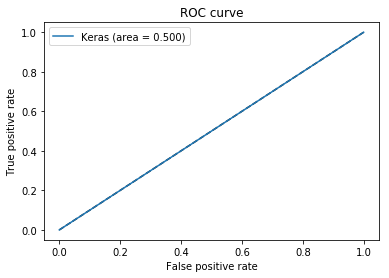

In [1]:
import os
import cv2
import random
import numpy as np
from numpy.lib.stride_tricks import as_strided

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten

from PIL import Image

data_set = []
data_label = []

training_data = []

input_path = "../input/brain_tumor_dataset"

CATEGORIES = ["no", "yes"]

"""
    Please ignore the pool2d function
"""

# def pool2d(input_matrix, kernel_size, stride, padding):

#     input_matrix = np.pad(input_matrix, padding, mode='constant')

#     output_w = (input_matrix.shape[0] - kernel_size)//stride + 1
#     output_h = (input_matrix.shape[1] - kernel_size)//stride + 1
#     output_shape = (output_w, output_h)

#     kernel_size = (kernel_size, kernel_size)

#     input_matrix_w = as_strided(input_matrix, shape = output_shape + kernel_size,
#                         strides = (stride*input_matrix.strides[0],
#                                    stride*input_matrix.strides[1]) + input_matrix.strides)

#     input_matrix_w = input_matrix_w.reshape(-1, *kernel_size)

#     return input_matrix_w.prod(axis=(1,2)).reshape(output_shape)


"""
    The show function simply takes in a numpy array and displays it as an image.
"""

def show(img_input):
    plt.imshow(img_input)
    plt.show()

def create_training_data():
    
    for category in CATEGORIES:
        path = os.path.join(input_path, category)
        category_index = CATEGORIES.index(category)
        for image in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                img_array = img_array.astype(np.float32)

                  #Please ignore this line
#                 img_array = pool2d(img_array, kernel_size=2, stride=2, padding=0)

                img_array = cv2.resize(img_array, (256, 256))
                training_data.append([img_array, category_index])
            except Exception as e:
                print(e)
                
create_training_data()

random.shuffle(training_data)

for feature, label in training_data:
    data_set.append(feature)
    data_label.append(label)
    

x_train, x_test, y_train, y_test = train_test_split(data_set, data_label, test_size = 0.1, 
                                                    random_state = 45)

data_set = np.array(x_train).reshape(-1, 256, 256, 1)

x_test = np.array(x_test).reshape(-1, 256, 256, 1)

data_set = data_set/255.0

model = Sequential()
model.add(Conv2D(128, (3,3), input_shape = data_set.shape[1:]))
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size = (2,2)))

model.add(Conv2D(128, (3,3)))
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

model.fit(data_set, y_train, batch_size = 32, epochs = 15, validation_split = 0.1)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

